In [336]:
# Load modules
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import pandas as pd

# LaTeX font
plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 17
plt.rcParams['font.size'] = font_size

# Add your own import statements if needed

In [249]:
# Load and unpack a compressed npy array
load_data = np.load('data_project2.npz')
data = load_data['arr_0']


# Remove data where data[:, -1, 1:5] = 0, i.e.
# where the particles get stuck in (0, 0)
data = data[np.sum(data[:,-1,1:5], axis=1) != 0]

N,time_steps, variables = data.shape
# Rng
rng = np.random.default_rng(seed=19)
# rng.shuffle(data)


In [250]:

# Split the data into training and validation sets
t_train = data[:int(N*0.9), :, 0]
x_2_train = data[:int(N*0.9),0,3].reshape(-1,1) @ np.ones((1, 1000))
y_2_train = data[:int(N*0.9),0,4].reshape(-1,1) @ np.ones((1, 1000))

t_val = data[-int(N*0.1)-1:, :, 0]
x_2_val = data[-int(N*0.1)-1:,0,3].reshape(-1,1) @ np.ones((1, 1000))
y_2_val = data[-int(N*0.1)-1:,0,4].reshape(-1,1) @ np.ones((1, 1000))

train_data = np.dstack((t_train, x_2_train, y_2_train))
val_data = np.dstack((t_val, x_2_val, y_2_val))

train_targets = data[:int(data.shape[0]*0.9), :, (1, 2, 3, 4)]
val_targets = data[-int(data.shape[0]*0.1)-1:, :, (1, 2, 3, 4)]

print(train_data.shape)
print(val_data.shape)


(6860, 1000, 3)
(763, 1000, 3)


In [326]:
# Helping functions
def get_data(idx):
    """
    Get one training instance from the data set at the index idx. 
    
    The data is assumed to be in an array `data`.
    
    Args:
        idx (int): An integer specifying which of the training example to fetch
        
    Returns:
        x (array): An array of shape (time_steps, 3) which specifies the input to
                   the neural network. The first column is the time and the second
                   and third columns specify the (x, y) coordinates of the second
                   particle. Note that the first particle is always assumed to be
                   at (1, 0) and the third particle can be inferred from the first
                   and second particle's position.
                   
        y (array): An array of shape (time_steps, 4) which specifies the output that 
                   is expected from the neural network.
                   
                   The first two columns specify the (x, y) coordinates of the first
                   particles and the next two columns give the coordinates of the 
                   second particle for the specified time (length of the columns).
                   The third particles position can be inferred from the first
                   and second particle's position.
    """
    raise NotImplementedError

def get_trajectories(pred, indx):
    """
    Gets the trajectories from a predicted output pred.
    
    Args:
        pred (array): An array of shape (N, 4) where N is the number of time
                      steps. The four columns give the positions of the particles
                      1 and 2 for all the time steps.
    Returns:
        p1, p2, p3 (tuple of arrays): Three arrays of dimensions (N, 2) where N is the number 
                             of time steps and the two columns for each array give 
                             the positions of the three particles (p1, p2, p3)
    """
    x1 = pred[indx,:,0];x2 = pred[indx,:,2]
    x3 = -x2 - x1
    y1 = pred[indx,:,1];y2 = pred[indx,:,3]
    y3 = -y1 -y2
    
    p1 = np.dstack((x1, y1))
    p2 = np.dstack((x2, y2))
    p3 = np.dstack((x3, y3))
    return p1, p2, p3 

def plot_trajectories(p1, p2, p3,model, ax=None, **kwargs):
    """
    Plots trajectories for points p1, p2, p3
    
    Args:
        p1, p2, p3 (array): Three arrays each of shape (n, 2) where n is the number
                            of time steps. Each array is the (x, y) position for the
                            particles
        ax (axis object): Default None, in which case a new axis object is created.
        kwargs (dict): Optional keyword arguments for plotting
    
    Returns:
        ax: Axes object
    """
    if ax is None:
        fig, ax = plt.subplots()
    ax.figure.set_size_inches(10, 8)
    ax.plot(p1[0,:,0], p1[0,:,1], label=f'$(x_1,y_1)$ {model}', **kwargs,color='tab:blue')
    ax.plot(p2[0,:,0], p2[0,:,1], label=f'$(x_2,y_2)$ {model}', **kwargs,color='tab:red')
    ax.plot(p3[0,:,0], p3[0,:,1], label=f'$(x_3,y_3)$ {model}', **kwargs,color='tab:green')
    ax.legend()
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    if model == 'True':
        ax.plot(p1[0,0,0], p1[0,0,1], marker='o' , **kwargs,color='tab:blue',markersize=10)
        ax.plot(p2[0,0,0], p2[0,0,1], marker='o', **kwargs,color='tab:red',markersize=10)
        ax.plot(p3[0,0,0], p3[0,0,1], marker='o', **kwargs,color='tab:green',markersize=10)
        ax.plot(p1[0,-1,0], p1[0,-1,1], marker='s' , **kwargs,color='tab:blue',markersize=10)
        ax.plot(p2[0,-1,0], p2[0,-1,1], marker='s', **kwargs,color='tab:red',markersize=10)
        ax.plot(p3[0,-1,0], p3[0,-1,1], marker='s', **kwargs,color='tab:green',markersize=10)
    return ax



In [176]:

def save_model(model, model_name):
    model_name = 'non_tuned_model'
    model.save(f'PATH/{model_name}.keras')    

def plot_history(history,model_name, save_training_curves = False):
    plt.figure(figsize=(8,6))
    for key in history.history.keys():
        plt.plot(history.history[key],label=key)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    if save_training_curves:
        plt.savefig(f'Training curve {model_name}.pdf')
        

In [177]:
pre_trained_model = keras.models.load_model('Breen_NN_project2.keras')
#pre_trained_model.summary()
pre_trained_model.trainable = False

batch_size = 5000

train_dataset = tf.data.Dataset.from_tensor_slices((train_data.reshape(-1,3), train_targets.reshape(-1,4))).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data.reshape(-1,3), val_targets.reshape(-1,4))).batch(batch_size)

pre_trained_model.summary(show_trainable=True)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ dense_78 (Dense)            │ (None, 128)           │        512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_79 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_80 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_81 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_82 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_83 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_84 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_85 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_86 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_87 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_88 (Dense)            │ (None, 4)             │        516 │   N   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 149,636 (1.14 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 149,636 (1.14 MB)

In [182]:
model_5_Dense = keras.models.Sequential([   
    keras.layers.Dense(64, activation='relu', input_shape=(3,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(4)
])

model_CNN = keras.models.Sequential([
    keras.layers.Conv1D(filters = 128, kernel_size = 3, activation='relu',input_shape=(3,1)),
    keras.layers.Conv1D(filters = 64, kernel_size = 2, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(4)
])

In [179]:
def training_models(model,epochs, train_data, val_data, loss_function=keras.losses.MeanAbsoluteError(), metric='mean_absolute_error', learning_rate=0.001, patience=15):

    ''' Function to train a model and return the history, model and time taken to train'''


    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,mode='min',restore_best_weights = True)

    model.compile(loss=loss_function,
                optimizer=tf.optimizers.Adam(learning_rate,0.5,0.5),
                metrics=[metric])

    start = time.time()
    history = model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[early_stopping])
    end = time.time()
    t = end-start
    print(f'Time to run: {t:.1f}s')

    return history,model,t

In [180]:
# Trandferred model

#name_of_last_layer = 'dense_87'

#print(pre_trained_model.get_layer(name_of_last_layer).output)
#x = pre_trained_model.get_layer(name_of_last_layer).output
#x = keras.layers.Dense(units=64, activation='relu')(x)
#x = keras.layers.Dense(units=64, activation='relu')(x)

#x = keras.layers.Dense(4,activation='relu')(x)

# Creating new combined model. Note that this is NOT a Sequential() model.
#model = keras.models.Model(inputs=pre_trained_model.input, outputs=x)

#print(model.summary(show_trainable=True))

In [187]:
epochs = 100
#history, model, t = training_models(model_5_Dense, epochs, train_dataset, val_dataset)

history_dense, model_dense, _ =  training_models(model_5_Dense, epochs, train_dataset, val_dataset)


#history, model, t = training_models(pre_trained_model, 100, 'mean_squared_error', 'mean_squared_error', 0.001, 10, train_dataset, val_dataset)

Epoch 1/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1466 - mean_absolute_error: 0.1466 - val_loss: 0.1307 - val_mean_absolute_error: 0.1307
Epoch 2/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1347 - mean_absolute_error: 0.1347 - val_loss: 0.1206 - val_mean_absolute_error: 0.1206
Epoch 3/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1280 - mean_absolute_error: 0.1280 - val_loss: 0.1144 - val_mean_absolute_error: 0.1144
Epoch 4/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1224 - mean_absolute_error: 0.1224 - val_loss: 0.1088 - val_mean_absolute_error: 0.1088
Epoch 5/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1189 - mean_absolute_error: 0.1189 - val_loss: 0.1111 - val_mean_absolute_error: 0.1111
Epoch 6/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1136 - mean_absolute_error: 0.1136 - val_loss: 0.1118 - val_mean_absolute_error: 0.1118
Epoch 7/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1116 - mea

In [164]:
def prediction(model, targets,data):
    trad = np.zeros((targets.shape))
    for time_step in range(targets.shape[1]):
        if time_step == 0:
            trad[:,time_step,:] = targets[:,time_step,:]
        else:
            trad[:,time_step,:] = model.predict(data[:,time_step,:],verbose=0) 
    return trad

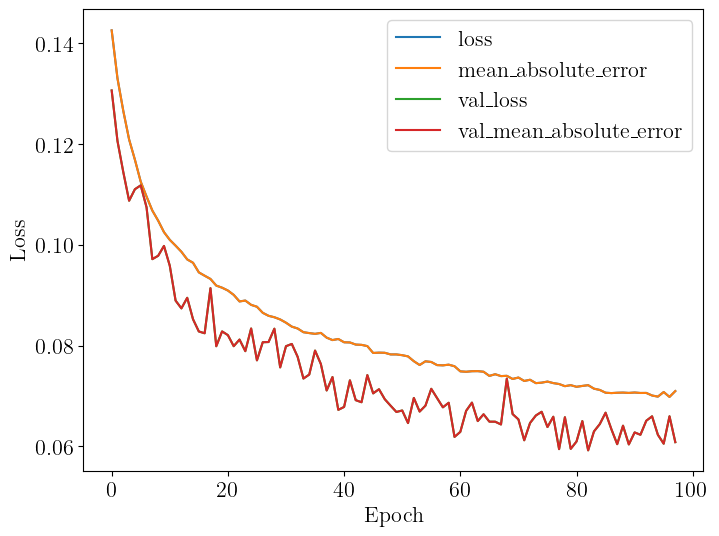

In [209]:
# Plot the training curves
plot_history(history_dense, 'model_5_Dense', save_training_curves = False)

In [210]:
tradject = prediction(model_dense, val_targets, val_data)

In [211]:
tradject_pre = prediction(pre_trained_model, val_targets, val_data)

<Axes: xlabel='$x$', ylabel='$y$'>

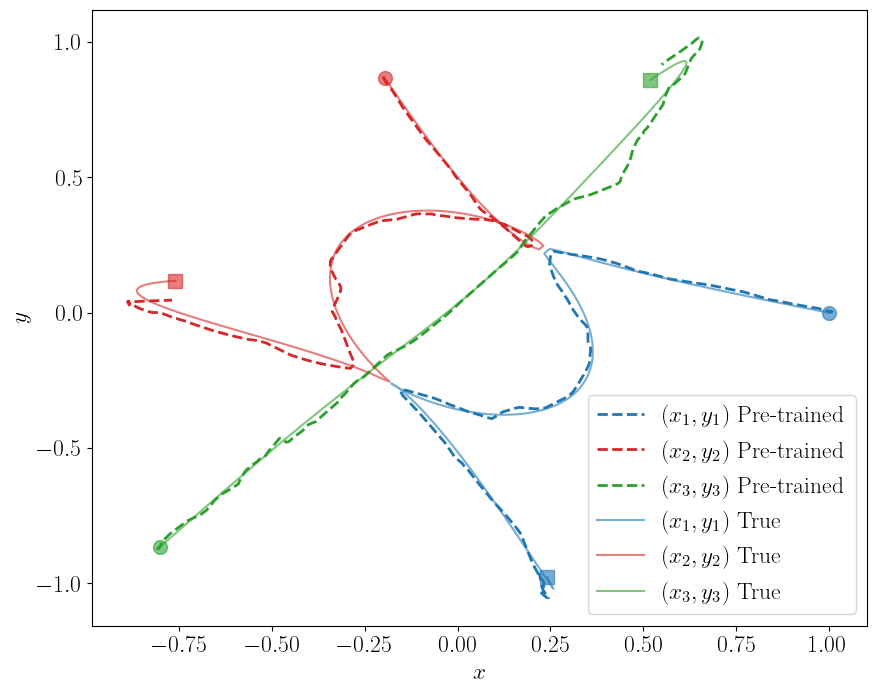

In [340]:
tradjectory = 2

p1, p2, p3 = get_trajectories(tradject, tradjectory)
plot_trajectories(p1,p2,p3,'Pre-trained', linestyle='--', ax=plt.gca(),alpha = 1,linewidth=2)

p1, p2, p3 = get_trajectories(val_targets, tradjectory)
plot_trajectories(p1,p2,p3,'True',ax=plt.gca(),alpha=0.6)

#plt.savefig('Trajectories_pre.svg')


In [214]:
import keras_tuner

# The chosen optimization
from keras_tuner.tuners import BayesianOptimization



In [215]:
def build_model_MyModel(hp):
  model_tuned = keras.Sequential([
    # First LSTM Layer
    keras.layers.Dense(units=64,activation='relu',input_shape=(3,)),
    keras.layers.Dense(units=64,activation='relu'),
    keras.layers.Dense(units=64,activation='relu'),

    keras.layers.Dense(4)
  ])
  model_tuned.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-5,1e-4,1e-3,1e-2,0.1,0.5])),
              loss = tf.losses.MeanAbsoluteError(),
              #loss=hp.Choice('loss_function',[loss_f for loss_f in loss.values()]),
              metrics=['mean_absolute_error'])

  return model_tuned

In [216]:
MAX_TRIALS = 10            # This was set a bit lower just to ensure that running times were kept low  
EXECUTION_PER_TRIAL = 2 

class MyTuner(keras_tuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    return super(MyTuner, self).run_trial(trial, *args, **kwargs)
  

tuner = MyTuner(
    build_model_MyModel,
    max_trials=MAX_TRIALS,
    objective='val_loss',
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='output',
    overwrite=True,
    num_initial_points=10, 
    project_name='Tuning_5_Dense')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [217]:
tune = True

if tune:

    noepochauto = 6  
    #es = keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)
    
    tuner.search(train_dataset, epochs=noepochauto, validation_data=val_dataset)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.1               |0.1               |learning_rate

Epoch 1/6
 761/1372 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4001 - mean_absolute_error: 0.4001

KeyboardInterrupt: 

In [196]:
model = tuner.get_best_models(num_models=1)[0]

# Print the hyperparameters from the best model

vals = tuner.get_best_hyperparameters(num_trials=5)[0].values
for keys,values in vals.items():
    print('%20s = %3.4g' %(keys,values))

model.summary()

       learning_rate = 0.001


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,836 (34.52 KB)

 Trainable params: 8,836 (34.52 KB)

 Non-trainable params: 0 (0.00 B)